<a href="https://colab.research.google.com/github/pparutto/BINF2025_TP4/blob/main/BINF2025_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BINF TP4 - Algorithmes d'alignement par HMM

Dans ce TP nous allons implémenter un algorithme d'alignement par chaine de Markov cachée.

## Notation

Soit un alignement $A$, sa profondeur $prof(A) = P$ est le nombre de séquences alignées, sa largeur $larg(A) = N$ est la taille (identique) de chacune de ses séquences et $A_{(k,l)}$ est le ième caractère de sa kème séquence avec $0 \geq k < P$ et $0 \geq l < N$. On note $P$:Acide Aminé $\rightarrow$ Entier la fonction qui associe une valeur entière unique dans [0,20] à chaque acide aminé et donnée par :




In [1]:
P = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7,
     "K": 8, "L": 9, "M": 10, "N": 11, "P": 12, "Q": 13, "R": 14, "S": 15,
     "T": 16, "V": 17, "W": 18, "Y": 19}

En plus, voici quelques fonctions de support pour charger des séquences d'un fichier fasta et sauvegarder et charger une chaîne de Markov :

In [2]:
def read_fasta(fname):
    #Read a fasta file with multiple entries.
    #Returns a list of sequences.
    res = []
    with open(fname, 'r') as f:
        tmp = None
        for line in f:
            if line.startswith(">"):
                if tmp:
                    res.append(tmp)
                tmp = ""
            else:
                tmp += line.rstrip()
        if tmp:
            res.append(tmp)
    return res

def save_HMM(T, e_M, e_I, f):
    #Save the HMM specified by (T, e_M, e_I) into the opened file f
    f.write("{}\n".format(T.shape[0]))
    for i in range(T.shape[0]):
        f.write(",".join(["{:.3f}".format(T[i,j]) for j in range(9)]) + "\n")
    for i in range(e_M.shape[0]):
        f.write(",".join(["{:.3f}".format(e_M[i,j]) for j in range(20)]) + "\n")
    for i in range(e_I.shape[0]):
        f.write(",".join(["{:.3f}".format(e_I[i,j]) for j in range(20)]) + "\n")

def load_HMM(f):
    #Load the HMM stored in the opened file f into matrices
    #Returns (T, e_M, e_I)
    line = f.readline()
    N = int(line.rstrip("\n"))
    T = np.zeros((N, 9))
    e_M = np.zeros((N, 20))
    e_I = np.zeros((N, 20))

    for i in range(N):
        T[i,:] = np.array([float(e) for e in f.readline().rstrip().split(",")])
    for i in range(N):
        e_M[i,:] = np.array([float(e) for e in f.readline().rstrip().split(",")])
    for i in range(N):
        e_I[i,:] = np.array([float(e) for e in f.readline().rstrip().split(",")])

    return (T, e_M, e_I)

## Exemples:
Vous trouverez des exemples de fichiers d'entrées et de sorties [ici](https://www.dropbox.com/scl/fo/llpj27nr17qkzrcc2w43f/ADdTZVnoqQYK1Cgrplggdao?rlkey=83glsunr3k3fgxhp4w4nidgxj&st=wqo11d1h&dl=0).

Voici un extrait :
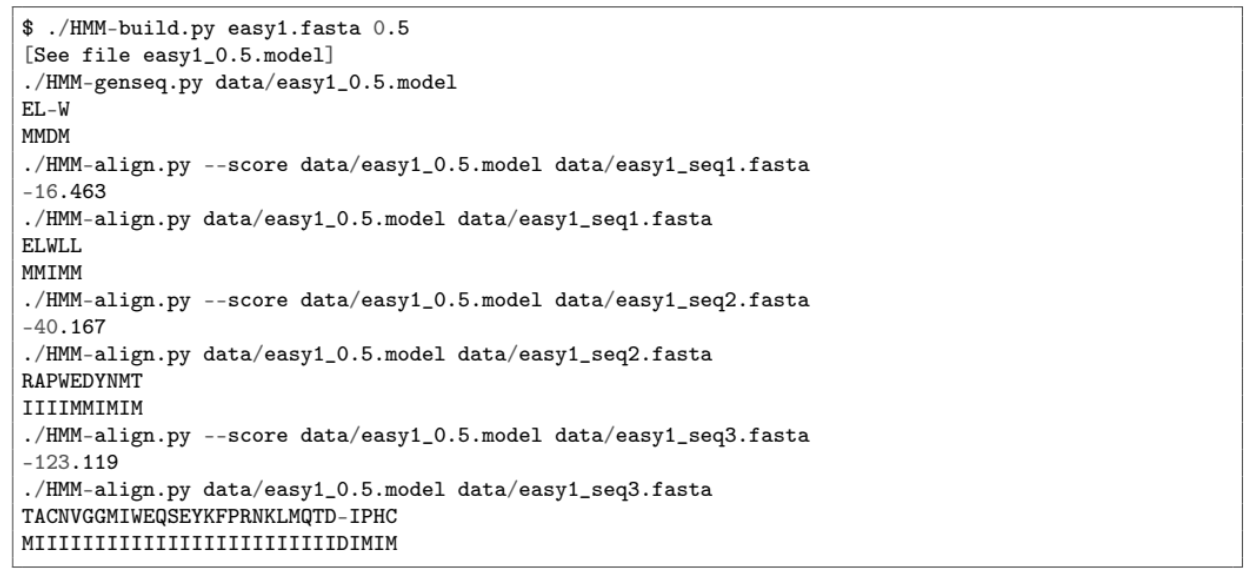

# Modèle Plan 9

On va utiliser le modèle de HMM Plan 9 vu en cours. Ce modèle est structuré selon les colonnes de l'alignement et possède 3 types d'états différents : $M$ représentant les correspondances et substitutions, $D$ représentant les délétions et $I$ représentant les insertions. Chaque colonne contient ces trois états sauf la première qui n'a pas d'état $D$. Les états $M$ et $I$ émettent des caractères et ont donc des vecteurs d'émissions associés, les états $D$ son silencieux.

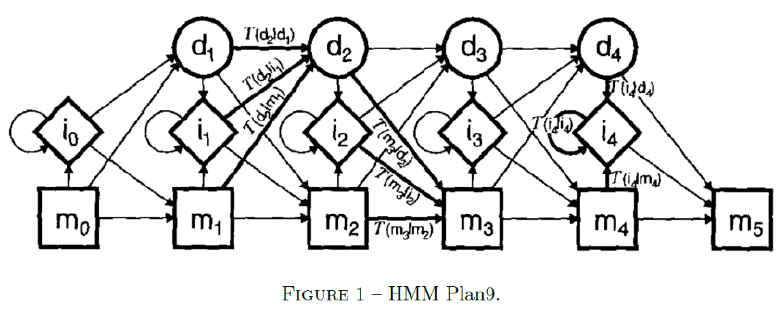

Une HMM représentant un alignement contenant $N$ colonnes est représenté par trois matrices :

1. **La matrice de transition** $T$ de taille $(N+1) \times 9$ où chaque ligne $T_u$ contient les $9$ probabilités de transition des états de la colonne $u$ $(M_u,I_u,D_u)$ vers leurs successeurs. L'ordre des transitions est : $M_u \rightarrow M_{(u+1)}, M_u \rightarrow D_{(u+1)}, M_u \rightarrow I_u, D_u \rightarrow M_{(u+1)}, D_u \rightarrow D_{(u+1)}, D_u \rightarrow I_u, I_u \rightarrow M_{(u+1)}, I_u \rightarrow D_{(u+1)}, I_u \rightarrow I_u$.

  La première colonne $u=0$ est spéciale, c'est l'état de départ du modèle, elle ne contient pas d'état $D$ donc les probabilités associées sont fixées à $0$. De la même manière, la dernière colonne ne possède que des transitions vers l'état $M$, les valeurs des autres transitions sont fixées à $0$.

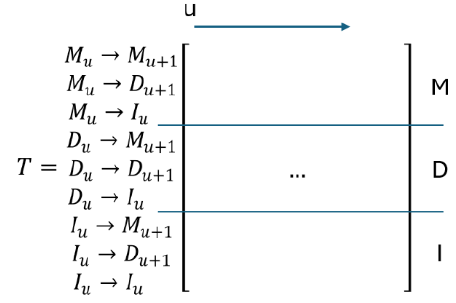

2. **Les matrices d'émissions** $e^M$ et $e^I$ de tailles $(N+1) \times 20$ où $e_{u,P(c)}^M$ et $e_{u,P(c)}^I$ contiennent respectivement la probabilité d'émission du caractère $c$ pour les états $M$ et $I$ de la colonne $u$. L'état $M$ de la première colonne n'émet pas de caractère donc $e_{0,*}^M=0$.

# Exercice 1 - Construction de la chaîne

Construire une HMM revient à remplir les matrices $T$, $e^M$ et $e^I$ à partir d'un alignement $A$. Pour commencer, on va déterminer la taille de la chaîne. Pour cela, on introduit le paramètre $α \in [0,1]$ qu'on va utiliser pour déterminer les colonnes à marquer dans $A$. Une colonne marquée correspond à une colonne de la chaîne.

---

Q1. Ecrire la fonction

mark_columns(A: list, alpha: float) -> list

qui prend en entrée un alignement (une liste de séquences protéiques de même taille) et une valeur de $\alpha$ et retourne la liste des indices des colonnes marquées. On marque une colonne quand elle contient une proportion de caractères "-" (de trou) $< \alpha$.

In [3]:
def mark_columns(A, alpha):
    nb_c = len(A[0])
    nb_l = len(A)
    res = []
    for i in range(nb_c):
        nb_gap = 0
        for l in A:
            if l[i] == '-':
                nb_gap += 1
        if nb_gap / nb_l < alpha:
            res.append(i)
    return res
        

In [4]:
#tests
A = [
    "ACGT-PQ--LMN-YF-",
    "MQS--TLAK-GNPR--",
    "KLM-DF--GQP-TASY",
    "R-YASD--FGHCVB--",
    "PQL-MNGT-ASD-YFR",
    "YWQ-T--PAKLMVS-D",
    "VBN-ASD-FGQW--RT",
    "G--QPYT--RNLKMF-",
    "TLA--GQP-MNSDYF-",
    "TQWVBN-ASD--TGPR"]
alpha = 0.3
mark_columns(A, alpha)

[0, 1, 2, 5, 9, 10, 11, 13]

---
Maintenant qu'on a $N$ colonnes marquées, on va construire la chaîne en tant que tel en suivant les etapes suivantes :

1. Construire la matrice $T$, de tailles $(N+1)\times 9$ et les matrices $e^M$ et $e^I$ de tailles $(N+1) \times 20$. Initialiser les valeurs de ces matrices à $1$ sauf les cas particuliers mentionnés ci-dessus.

2. Pour remplir les matrices, on va parcourir chaque séquence de l’alignement et commencer par déterminer à quelle colonne $k$ et état $π_k$ est associée chaque caractère, puis mettre à jours les matrices en utilisant la procédure suivant:
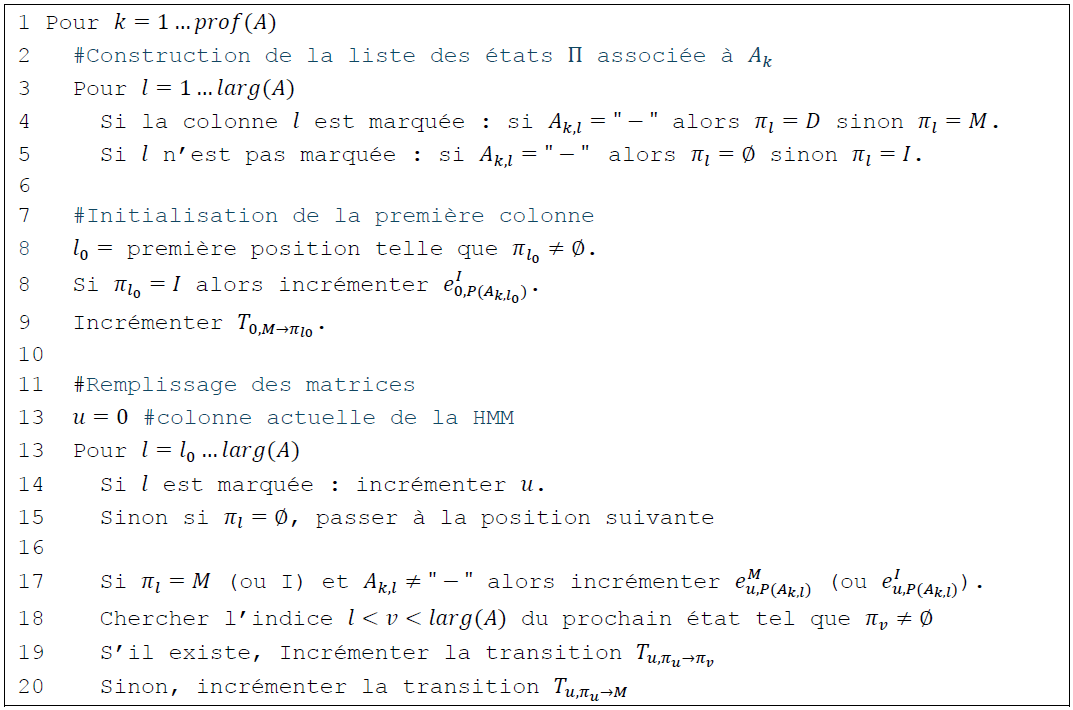

3. Normaliser chaque élément de $T$ de telle sorte à ce que la somme des probabilités de transition pour chaque état de chaque colonne soit égale à $1$. Normaliser $e^M$ et $e^I$ de telle sorte à ce que la somme des probabilités d'émission des caractères pour chaque colonne soit égale à $1$.

Remarque : si vous rencontrez un caractère X dans les séquences alors ignorez le pour le remplissage de $e^M$ et $e^I$.

---

Q2. Ecrire la fonction

build_HMM(A: list, mark: list) -> (T, eM, eI)

qui retourne les matrices $T$, $eM$ et $eI$ representant la chaine construite a partir de l'alignement $A$ et de la liste de colonnes marques $mark$.

In [10]:
import numpy as np

def build_HMM(A, mark):
    N = len(mark)
    
    # initialisation des matrices avec des 1
    T = np.ones((N+1, 9))
    eM = np.ones((N+1, 20))
    eI = np.ones((N+1, 20))
    
    # remplissage avec des 0 de cas particuliers
    T[[3,4,5],0] = 0
    T[3:9,-1] = 0
    eM[:,0] = 0
    
    # remplissage en suivant la procédure
    prof = len(A)
    larg = len(A[0])
    T_inds = {"M": 0, "D": 1, "I": 2}
    for k in range(prof):
        
        # construction de pi associé à Ak
        pi = []
        for l in range(larg):
            if l in mark:
                if A[k][l] == '-':
                    pi.append("D")
                else:
                    pi.append("M")
            else:
                if A[k][l] == '-':
                    pi.append(0)
                else:
                    pi.append("I")

        # Initialisation de la première colonne
        l0 = next((i for i, state in enumerate(pi) if state != "∅"), None)
        if pi[l0] == "I":
            eM[P[A[k][l0]], 0] += 1
        T[0 + T_inds[pi[l0]] , 0] += 1

        # Remplissage des matrices
        u = 0
        for l in range(l0, larg):
            if l in mark:
                u += 1
            elif pi[l] == 0:
                continue
            #### reprendre ligne 17 de l'algo
                
            if A[k][l] != "-":
                if pi[l] == "M":
                    eM[P[A[k][l]], u] += 1
                if pi[l] == "I":
                    eI[P[A[k][l]], u] += 1 

            vexists = False
            for v in range(l+1, larg):
                if pi[v] == 0:
                    T[T_inds[pi[u]] * 3 + T_inds[pi[v]] , u] += 1
                    vexists = True
            if not vexists:
                T[T_inds[pi[u]] * 3] , u]

build_HMM(A, mark_columns(A, alpha))

KeyError: 0

# Exercice 2 : Alignement d'une séquence sur le modèle

Maintenant qu'on a construit le modèle, on peut l'utiliser pour aligner des séquences sur celui-ci. Pour cela, on va utiliser l'algorithme de Viterbi qui est un algorithme de programmation dynamique (structure similaire à Levenshtein) qui va calculer la séquence d'états cachés $\Pi$ de probabilité maximale étant donnée la séquence $s$. A partir de ces états, on pourra calculer le score de l'alignement ainsi que la superposition correspondante.


Pour une HMM de taille $N$ et une séquence à aligner de taille $M$, on va remplir une matrice de score $V$ et de retour $B$ de taille $(3N+1) \times (M+1)$ où $3N$ est le nombre d'état de la HMM, + 1 pour l'état spécial END et $M+1$ car la première colonne correspond à la séquence vide (comme pour l'alignement).

* Bords : La première colonne et les premières et secondes lignes sont fixées à $-\infty$ sauf la case haut-gauche qui vaut $0$ : $v_{(i,0)}= -\infty$ pour $i=1…(3N+1)$, $v_{(0,j)}= -\infty$ pour $j=1…(M+1)$, $v_{(1,j)}= - \infty$ pour $j=0…(M+1)$ et $v_{0,0}=0$. Notez que $log⁡(1)=0$, donc en donnant cette valeur on indique une probabilité $1$ de démarrer dans l'état de départ. Pour $B$, la première colonne et les premières et deuxièmes lignes sont initialisées à la valeur vide : $b_{(i,0)}=\emptyset$ pour $i=0…(3N+1)$ et $b_{(0,j)}=b_{(i,j)}=\emptyset$ pour $j=0…(M+1)$.

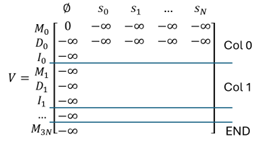

* Remplissage de V : on va utiliser les équations suivantes pour remplir la case à la position $2 \leq i < 3N$ (indice de la HMM) et $0< j < M$ (indice de la séquence) :

1. Si on est sur un état $M$ ($i$ multiple de $3$) et $i>2$, alors

$$
\begin{equation*}
v_{(i,j)}=log⁡(e_{(i//3,P(s_{(j-1)}))}^M + \epsilon) + max
\begin{cases}v_{(i-3,j-1)}+log⁡(t_{((i-3)//3,M \rightarrow M)})\\v_{(i-2,j-1)}+log⁡(t_{((i-2)//3,D \rightarrow M)})\\ v_{(i-1,j-1)}+log⁡(t_{((i-1)//3,I \rightarrow M))}) \end{cases},
\end{equation*}
$$

  Où $\epsilon > 0$ est un paramètre de l'algorithme et $a//b$ est la division entière de $a$ par $b$.

  2. Si on est sur un état $D$ ($i-1$ multiple de $3$) et $i > 2$, alors

$$
\begin{equation*}
v_{(i,j)} = max \begin{cases} v_{(i-4,j)} + log⁡(t_{((i-4)//3,M \rightarrow D)})\\ v_{(i-3,j)} + log⁡(t_{((i-3)//3,D \rightarrow D)})\\ v_{(i-2,j)} + log⁡(t_{((i-2)//3,I \rightarrow D))}) \end{cases}
\end{equation*}
$$

  3. Si on est sur un état $I$ ($i - 2$ multiple de $3$) alors

$$
\begin{equation*}
v_{(i,j)} = log⁡(e_{(i//3,P(s_{(j-1)}))}^I + \epsilon) + max \begin{cases} v_{(i-2,j-1)} + log⁡(t_{((i-2)//3,M \rightarrow I)})\\ v_{(i-1,j-1)} + log⁡(t_{((i-1)//3,D \rightarrow I)})\\ v_{(i,j-1)} + log⁡(t_{(i//3,I \rightarrow I)})\end{cases}
\end{equation*}
$$

4. La dernière ligne $i=3N$ est un cas particulier (c'est l'état de fin), on la remplie comme un état $M$ qui n'émet aucun caractère (donc on néglige la première partie de l'équation avec le log) et sans changer de position dans la séquence (utiliser j au lieu de j-1)  :

$$
\begin{equation*}
v_{(3N,j)}= max \begin{cases} v_{(i-3,j)} + log⁡(t_{((i-3)//3,M \rightarrow M)})\\ v_{(i-2,j)} + log⁡(t_{((i-2)//3,D \rightarrow M)})\\ v_{(i-1,j)} + log⁡(t_{((i-1)//3,I \rightarrow M)}) \end{cases}
\end{equation*}
$$

En cas d'égalité dans les scores, suit l'ordre : $M > D > I$.

Le score d'alignement est donnée dans la case base-droite de $V$.

* Remplissage de $B$ : en même temps que l'on remplit la matrice $V$ on va aussi remplir la matrice de retour $B$ tel que $b_{(i,j)} = (k,l)$ les coordonnées de la case utilisée pour remplir $v_{(i,j)}$.

---
Q1. Ecrire la fonction

viterbi_fwd(T: array, eM: array, eI: array, s: str) -> (array, array)

qui retourne les matrices $V$ et $B$ a partir de la chaine (T, eM, eI) et de la sequence $s$.

In [ ]:
#Votre code ici


**Etape de retour** : L'étape de retour permet de reconstituer la séquence des états cachés $\Pi$ à partir de laquelle on obtient la superposition des séquences.

On va démarrer de la case bas-droite de $B$ et se déplacer en suivant les coordonnées des cases de $B$ jusqu'à atteindre une valeur nulle $\emptyset$. Pour chaque nouvel état visité sauf le premier, on ajoute son type au début de la séquence $\Pi$ et on met à jour la superposition :

*  Si c'est un état $M$ ou $I$, on écrit $s_{(j-1)}$ (la première colonne de $V$ et $B$ correspond à la séquence vide).
*  Si c'est un état $D$ on écrit « - ».

---
Q2. Ecrire la fonction

viterbi_bwd(V: array, B: array, s: str) -> (float, str, str)

qui retourne les matrices le score d'alignement, la séquence d'états et la séquence $s$ alignée etant donnée les matrices $V$ et $B$.



In [ ]:
#Votre code ici